In [1]:
# Install necessary packages
!pip install networkx matplotlib seaborn numpy

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)


In [2]:
# Parameters
n_nodes = 1000      # Number of nodes
p_edge = 0.005      # Edge probability for Erdős-Rényi graph

# Directed Erdős-Rényi Graph
G = nx.gnp_random_graph(n_nodes, p_edge, directed=True)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 1000
Number of edges: 4919


In [3]:
# Compute SCCs
scc_list = list(nx.strongly_connected_components(G))
largest_scc = max(scc_list, key=len)

print(f"Number of SCCs: {len(scc_list)}")
print(f"Size of largest SCC: {len(largest_scc)}")


Number of SCCs: 23
Size of largest SCC: 978


In [4]:
# Subgraph of largest SCC to compute distances
G_scc = G.subgraph(largest_scc).copy()

# Average shortest path length (if SCC is strongly connected)
if nx.is_strongly_connected(G_scc):
    avg_dist = nx.average_shortest_path_length(G_scc)
    print(f"Average distance in largest SCC: {avg_dist:.2f}")
else:
    print("Largest SCC not strongly connected, distances not defined.")


Average distance in largest SCC: 4.49


In [6]:
def perturb_graph(G, add_frac=0.01, remove_frac=0.01):
    G_perturbed = G.copy()

    # Remove edges
    n_remove = int(remove_frac * G.number_of_edges())
    edges_list = list(G_perturbed.edges())  # Convert to list
    if n_remove > 0 and len(edges_list) > 0:
        remove_edges = np.random.choice(len(edges_list), n_remove, replace=False)
        G_perturbed.remove_edges_from([edges_list[i] for i in remove_edges])

    # Add random edges
    n_add = int(add_frac * G.number_of_edges())
    possible_edges = list(set((i, j) for i in G.nodes() for j in G.nodes() if i != j) - set(G_perturbed.edges()))
    if n_add > 0 and len(possible_edges) > 0:
        add_indices = np.random.choice(len(possible_edges), n_add, replace=False)
        G_perturbed.add_edges_from([possible_edges[i] for i in add_indices])

    return G_perturbed


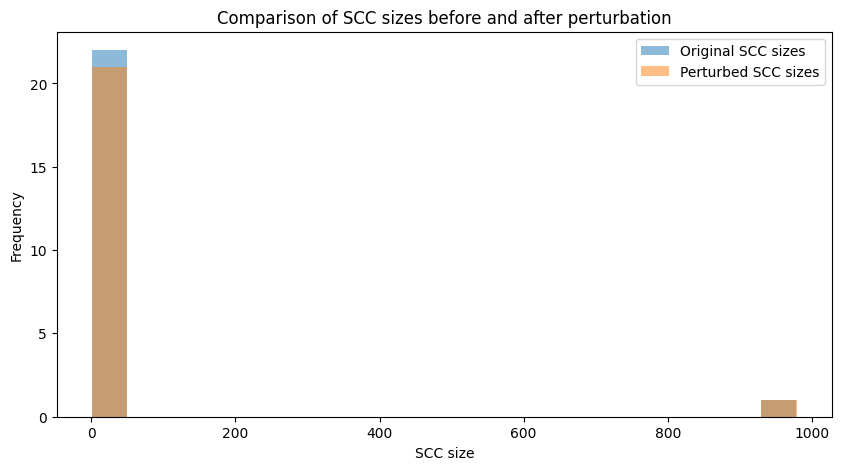

In [8]:
# Perturb the graph
G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)

# Compute SCCs of the perturbed graph
scc_list_pert = list(nx.strongly_connected_components(G_pert))

# Compare SCC sizes before and after perturbation
sizes_before = [len(scc) for scc in scc_list]
sizes_after = [len(scc) for scc in scc_list_pert]

# Plot the comparison
plt.figure(figsize=(10,5))
plt.hist(sizes_before, bins=20, alpha=0.5, label='Original SCC sizes')
plt.hist(sizes_after, bins=20, alpha=0.5, label='Perturbed SCC sizes')
plt.xlabel('SCC size')
plt.ylabel('Frequency')
plt.title('Comparison of SCC sizes before and after perturbation')
plt.legend()
plt.show()


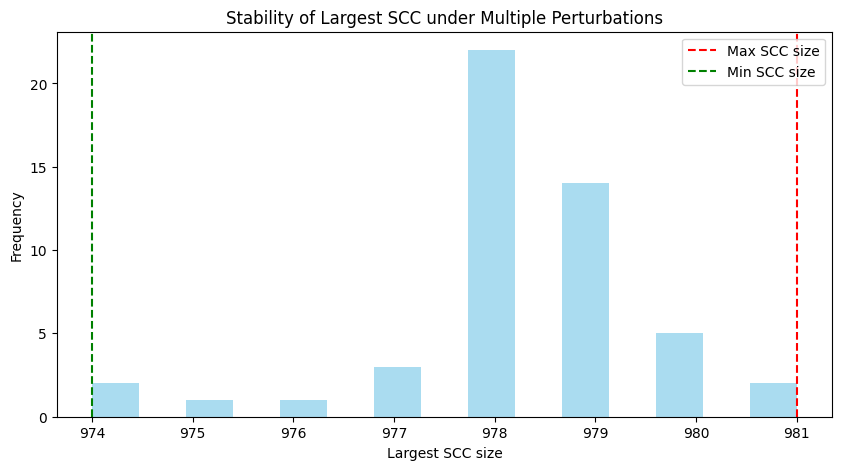

In [9]:
num_iterations = 50  # number of perturbations
largest_scc_sizes = []

for i in range(num_iterations):
    G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)
    scc_list_pert = list(nx.strongly_connected_components(G_pert))
    largest_scc = max(len(scc) for scc in scc_list_pert)
    largest_scc_sizes.append(largest_scc)

# Visualize the distribution of largest SCC sizes
plt.figure(figsize=(10,5))
plt.hist(largest_scc_sizes, bins=15, alpha=0.7, color='skyblue')
plt.axvline(max(largest_scc_sizes), color='r', linestyle='dashed', label='Max SCC size')
plt.axvline(min(largest_scc_sizes), color='g', linestyle='dashed', label='Min SCC size')
plt.xlabel('Largest SCC size')
plt.ylabel('Frequency')
plt.title('Stability of Largest SCC under Multiple Perturbations')
plt.legend()
plt.show()


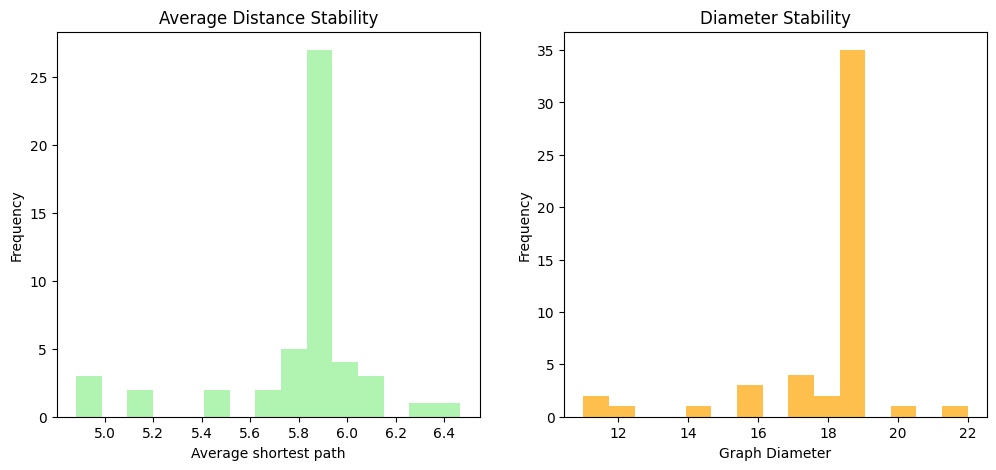

In [12]:
avg_distances = []
diameters = []

for i in range(num_iterations):
    G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)

    # Convert to strongly connected subgraph for distance computation
    if nx.is_strongly_connected(G_pert):
        avg_distances.append(nx.average_shortest_path_length(G_pert))
        diameters.append(nx.diameter(G_pert))
    else:
        # compute metrics for largest SCC only
        scc_list_pert = list(nx.strongly_connected_components(G_pert))
        largest_scc = max(scc_list_pert, key=len)
        subgraph = G_pert.subgraph(largest_scc)
        avg_distances.append(nx.average_shortest_path_length(subgraph))
        diameters.append(nx.diameter(subgraph))

# Plot stability metrics
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(avg_distances, bins=15, alpha=0.7, color='lightgreen')
plt.xlabel('Average shortest path')
plt.ylabel('Frequency')
plt.title('Average Distance Stability')

plt.subplot(1,2,2)
plt.hist(diameters, bins=15, alpha=0.7, color='orange')
plt.xlabel('Graph Diameter')
plt.ylabel('Frequency')
plt.title('Diameter Stability')

plt.show()


In [15]:
# Function to perturb the graph
def perturb_graph(G, add_frac=0.01, remove_frac=0.01):
    G_perturbed = G.copy()

    # Remove edges
    n_remove = int(remove_frac * G.number_of_edges())
    edges_list = list(G_perturbed.edges())
    if n_remove > 0:
        remove_edges = np.random.choice(len(edges_list), n_remove, replace=False)
        G_perturbed.remove_edges_from([edges_list[i] for i in remove_edges])

    # Add edges
    n_add = int(add_frac * G.number_of_edges())
    nodes = list(G_perturbed.nodes())
    for _ in range(n_add):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_perturbed.has_edge(u,v):
            G_perturbed.add_edge(u,v)

    return G_perturbed

# Example: original graph
G = nx.gnp_random_graph(50, 0.05, directed=True)
scc_list = list(nx.strongly_connected_components(G))
sizes_before = [len(scc) for scc in scc_list]

# Run multiple perturbation iterations
n_iterations = 10
all_sizes_after = []

for _ in range(n_iterations):
    G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)
    scc_list_pert = list(nx.strongly_connected_components(G_pert))
    all_sizes_after.append([len(scc) for scc in scc_list_pert])

# Compute average largest SCC size after perturbation
largest_scc_sizes = [max(sizes) for sizes in all_sizes_after]
print("Average largest SCC size after perturbation:", np.mean(largest_scc_sizes))

# Optional: track average shortest path length and diameter
for i, G_pert in enumerate([perturb_graph(G,0.01,0.01) for _ in range(5)]):
    if nx.is_strongly_connected(G_pert):
        print(f"Iteration {i}: avg shortest path:", nx.average_shortest_path_length(G_pert))
        print(f"Iteration {i}: diameter:", nx.diameter(G_pert))


Average largest SCC size after perturbation: 39.1



--- Analyzing Erdős-Rényi ---

--- Analyzing Scale-Free (BA) ---


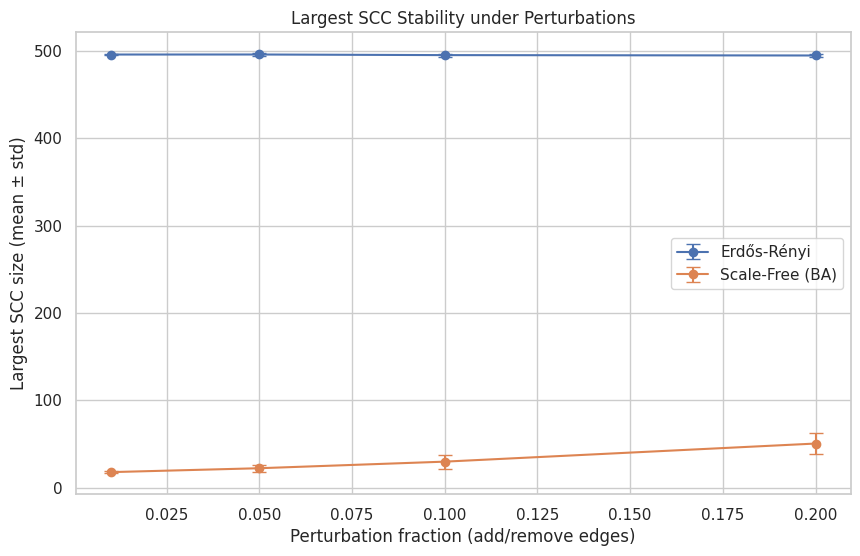

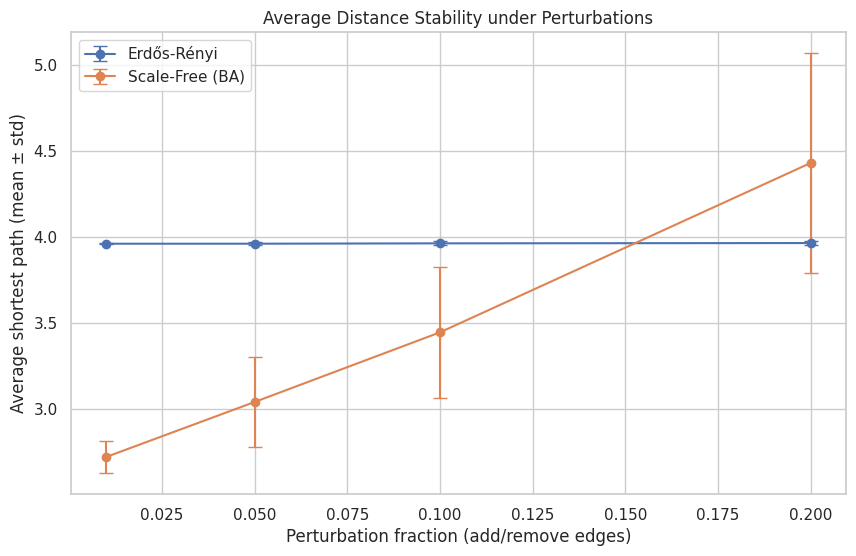

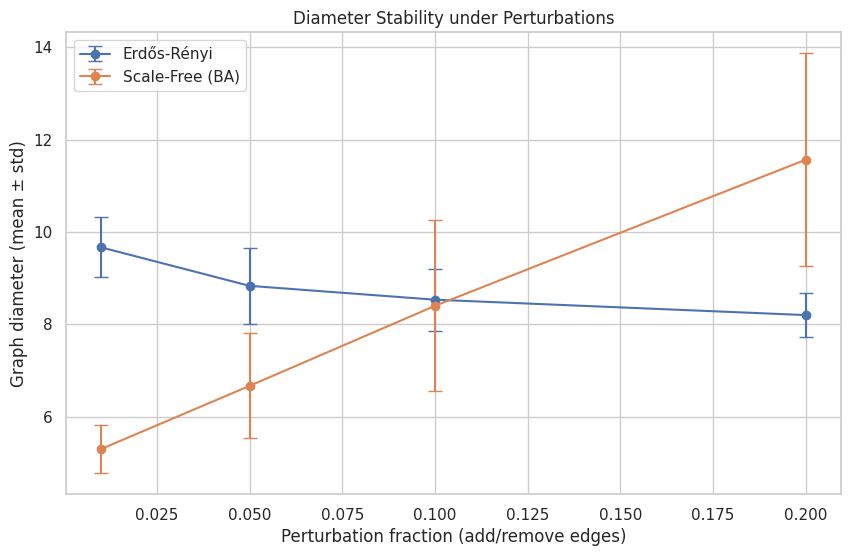

In [16]:
sns.set(style="whitegrid")
np.random.seed(42)

# -------------------------------
# Function to perturb a graph
# -------------------------------
def perturb_graph(G, add_frac=0.01, remove_frac=0.01):
    G_pert = G.copy()

    # Remove edges
    n_remove = int(remove_frac * G.number_of_edges())
    edges_list = list(G_pert.edges())
    if n_remove > 0 and len(edges_list) > 0:
        remove_edges = np.random.choice(len(edges_list), n_remove, replace=False)
        G_pert.remove_edges_from([edges_list[i] for i in remove_edges])

    # Add edges
    n_add = int(add_frac * G.number_of_edges())
    nodes = list(G_pert.nodes())
    possible_edges = list(set((i,j) for i in nodes for j in nodes if i != j) - set(G_pert.edges()))
    if n_add > 0 and len(possible_edges) > 0:
        add_indices = np.random.choice(len(possible_edges), n_add, replace=False)
        G_pert.add_edges_from([possible_edges[i] for i in add_indices])

    return G_pert

# -------------------------------
# Parameters
# -------------------------------
n_nodes = 500
p_edge = 0.01
perturb_fractions = [0.01, 0.05, 0.1, 0.2]  # fractions of edges to add/remove
n_iterations = 30  # number of perturbations per fraction

# -------------------------------
# Graph Models
# -------------------------------
graph_models = {
    "Erdős-Rényi": nx.gnp_random_graph(n_nodes, p_edge, directed=True),
    "Scale-Free (BA)": nx.scale_free_graph(n_nodes, seed=42).to_directed()
}

# -------------------------------
# Analysis Loop
# -------------------------------
results = []

for model_name, G in graph_models.items():
    print(f"\n--- Analyzing {model_name} ---")

    for frac in perturb_fractions:
        largest_scc_list = []
        avg_path_list = []
        diameter_list = []

        for _ in range(n_iterations):
            G_pert = perturb_graph(G, add_frac=frac, remove_frac=frac)

            # Strongly connected components
            sccs = list(nx.strongly_connected_components(G_pert))
            largest_scc = max(sccs, key=len)
            largest_scc_list.append(len(largest_scc))

            # Distance metrics
            subgraph = G_pert.subgraph(largest_scc).copy()
            if nx.is_strongly_connected(subgraph):
                avg_path_list.append(nx.average_shortest_path_length(subgraph))
                diameter_list.append(nx.diameter(subgraph))
            else:
                avg_path_list.append(np.nan)
                diameter_list.append(np.nan)

        results.append({
            "model": model_name,
            "perturb_frac": frac,
            "largest_scc_mean": np.nanmean(largest_scc_list),
            "largest_scc_std": np.nanstd(largest_scc_list),
            "avg_path_mean": np.nanmean(avg_path_list),
            "avg_path_std": np.nanstd(avg_path_list),
            "diameter_mean": np.nanmean(diameter_list),
            "diameter_std": np.nanstd(diameter_list)
        })

# -------------------------------
# Convert results to DataFrame
# -------------------------------
import pandas as pd
df = pd.DataFrame(results)
df

# -------------------------------
# Visualization: Largest SCC vs Perturbation
# -------------------------------
plt.figure(figsize=(10,6))
for model_name in df['model'].unique():
    subset = df[df['model']==model_name]
    plt.errorbar(subset['perturb_frac'], subset['largest_scc_mean'],
                 yerr=subset['largest_scc_std'], label=model_name, marker='o', capsize=5)
plt.xlabel('Perturbation fraction (add/remove edges)')
plt.ylabel('Largest SCC size (mean ± std)')
plt.title('Largest SCC Stability under Perturbations')
plt.legend()
plt.show()

# -------------------------------
# Visualization: Average Distance vs Perturbation
# -------------------------------
plt.figure(figsize=(10,6))
for model_name in df['model'].unique():
    subset = df[df['model']==model_name]
    plt.errorbar(subset['perturb_frac'], subset['avg_path_mean'],
                 yerr=subset['avg_path_std'], label=model_name, marker='o', capsize=5)
plt.xlabel('Perturbation fraction (add/remove edges)')
plt.ylabel('Average shortest path (mean ± std)')
plt.title('Average Distance Stability under Perturbations')
plt.legend()
plt.show()

# -------------------------------
# Visualization: Diameter vs Perturbation
# -------------------------------
plt.figure(figsize=(10,6))
for model_name in df['model'].unique():
    subset = df[df['model']==model_name]
    plt.errorbar(subset['perturb_frac'], subset['diameter_mean'],
                 yerr=subset['diameter_std'], label=model_name, marker='o', capsize=5)
plt.xlabel('Perturbation fraction (add/remove edges)')
plt.ylabel('Graph diameter (mean ± std)')
plt.title('Diameter Stability under Perturbations')
plt.legend()
plt.show()


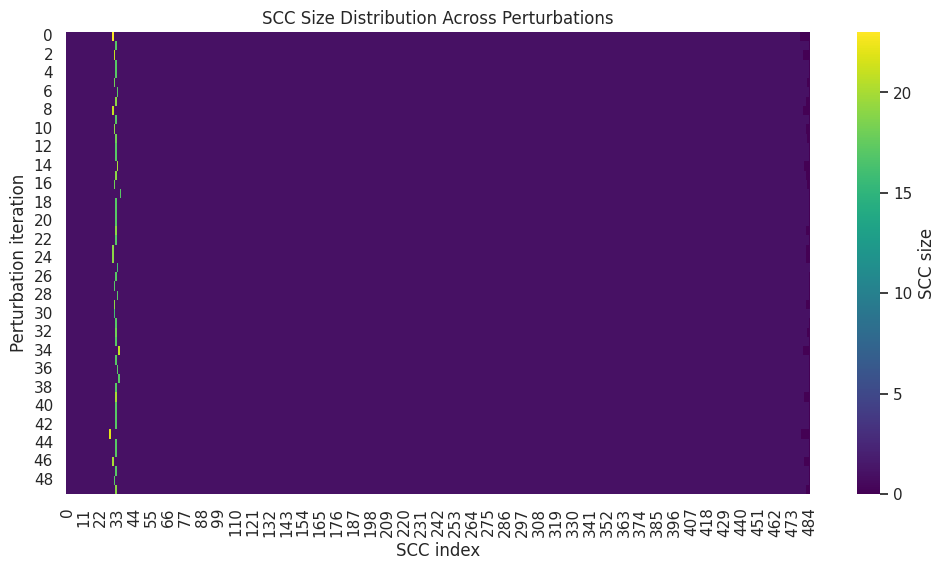

In [17]:
# Parameters
num_iterations = 50
all_scc_sizes = []

for i in range(num_iterations):
    G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)
    scc_list_pert = list(nx.strongly_connected_components(G_pert))
    all_scc_sizes.append([len(scc) for scc in scc_list_pert])

# Convert to a padded matrix for heatmap (rows = iteration, cols = SCCs)
max_scc_count = max(len(sizes) for sizes in all_scc_sizes)
scc_matrix = np.array([sizes + [0]*(max_scc_count - len(sizes)) for sizes in all_scc_sizes])

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(scc_matrix, cmap="viridis", cbar_kws={'label': 'SCC size'})
plt.xlabel("SCC index")
plt.ylabel("Perturbation iteration")
plt.title("SCC Size Distribution Across Perturbations")
plt.show()


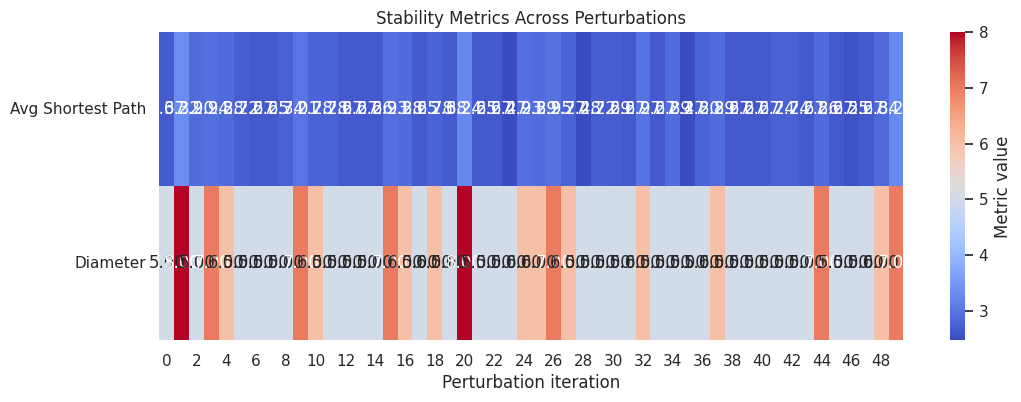

In [18]:
avg_distances = []
diameters = []

for i in range(num_iterations):
    G_pert = perturb_graph(G, add_frac=0.01, remove_frac=0.01)
    scc_list_pert = list(nx.strongly_connected_components(G_pert))
    largest_scc = max(scc_list_pert, key=len)
    subgraph = G_pert.subgraph(largest_scc)

    avg_distances.append(nx.average_shortest_path_length(subgraph))
    diameters.append(nx.diameter(subgraph))

# Combine metrics into a 2-row heatmap
metrics_matrix = np.vstack([avg_distances, diameters])

plt.figure(figsize=(12,4))
sns.heatmap(metrics_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Metric value'})
plt.yticks([0.5,1.5], ['Avg Shortest Path', 'Diameter'], rotation=0)
plt.xlabel("Perturbation iteration")
plt.title("Stability Metrics Across Perturbations")
plt.show()


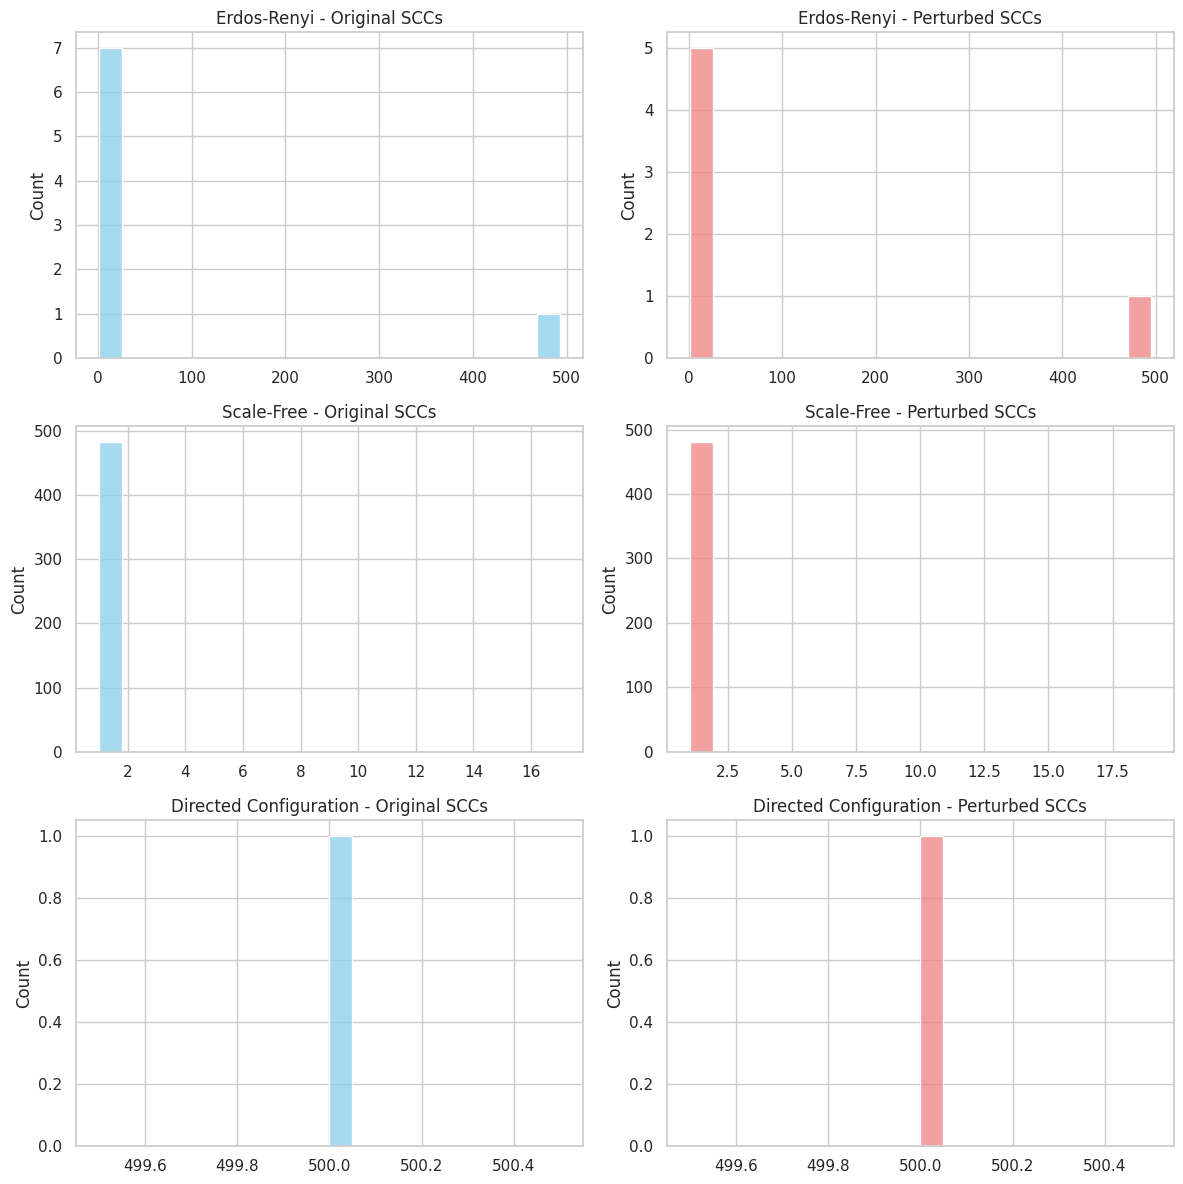

In [19]:
# Define multiple graph models
graphs = {
    "Erdos-Renyi": nx.gnp_random_graph(500, 0.01, directed=True),
    "Scale-Free": nx.scale_free_graph(500).to_directed(),
    "Directed Configuration": nx.directed_configuration_model(
        [3]*500, [3]*500, create_using=nx.DiGraph()
    )
}

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i, (name, G_model) in enumerate(graphs.items()):
    # Original SCC sizes
    scc_orig = [len(scc) for scc in nx.strongly_connected_components(G_model)]
    sns.histplot(scc_orig, bins=20, ax=axes[i,0], color='skyblue')
    axes[i,0].set_title(f"{name} - Original SCCs")

    # Perturb & SCC sizes
    G_pert = perturb_graph(G_model, add_frac=0.01, remove_frac=0.01)
    scc_pert = [len(scc) for scc in nx.strongly_connected_components(G_pert)]
    sns.histplot(scc_pert, bins=20, ax=axes[i,1], color='lightcoral')
    axes[i,1].set_title(f"{name} - Perturbed SCCs")

plt.tight_layout()
plt.show()
